<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#CartPole" data-toc-modified-id="CartPole-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>CartPole</a></span></li><li><span><a href="#MountainCar" data-toc-modified-id="MountainCar-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>MountainCar</a></span></li></ul></div>

# Reinforcement Learning - Q Learning with bins

Made by Carlo di Francescantonio based on the course *Advanced AI: Deep Reinforcement Learning* from Udemy. In this notebook we study the Q-Learning approach with bins.

In [1]:
# Libraries for RL
import numpy as np
import gym
from gym import wrappers
import matplotlib.pyplot as plt

# Libraries for MP4 videos
import io
import base64
from IPython.display import HTML

In [2]:
# Play one episode
def play_episode(env, decision_function, param = None):
    observation = env.reset()
    done = False
    idx = 0
    while not done:
        #env.render()
        action = decision_function(env,observation,param)
        observation, reward, done, _ = env.step(action)
        idx +=1
    return(idx)

# Play multiple episodes
def play_multiple_episodes(env, decision_function, N, play_video = True, param = None, print_results=True):
    episodes_idx = np.empty(N)
    for i in range(N-1):
        episodes_idx[i] = play_episode(env, decision_function, param)
        
    # Save the video
    if play_video == True:
        env = wrappers.Monitor(env, "./gym-results", force=True)
        episodes_idx[N-1] = play_episode(env, decision_function, param)
    # Dont save the video
    else:
        episodes_idx[N-1] = play_episode(env, decision_function, param)
        
    env.close()
    
    if print_results == True:
        print("Min Duration: ",episodes_idx.min())
        print("Average Duration: ",episodes_idx.mean())
        print("Max Duration: ",episodes_idx.max())
        print("Standard Deviation: ",round(episodes_idx.std(),2))
    
    # Show the video
    if play_video == True:
        video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
        encoded = base64.b64encode(video)
        graph = HTML(data='''<video width="980" height="auto" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii')))
        display(graph)
        
    return(episodes_idx.mean())

# Determine Bin Value
def to_bin(value, bins):
    return np.digitize(x=[value], bins=bins)[0]

def build_state(features):
    return ("-".join(map(lambda feature: str(int(feature)), features)))

def decision_Q(env,observation,param=None):
        state = []
        for idx,obs in enumerate(observation):
            state.append(to_bin(obs,env_bins[idx]))
        state = build_state(state)
        if state not in Q:
            Q[state] = np.random.uniform(low=-1, high=1, size=env.action_space.n)
        return(np.argmax(Q[state]))

## CartPole
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.

In [3]:
# Cartpole environment from gym
CartPole = gym.make('CartPole-v0')
env = CartPole

In [4]:
cart_position_bins = np.linspace(-2.4, 2.4, 14)
cart_velocity_bins = np.linspace(-2, 2, 14)
pole_angle_bins = np.linspace(-0.4, 0.4, 14)
pole_velocity_bins = np.linspace(-3.5, 3.5, 14)

env_bins = [cart_position_bins,cart_velocity_bins,pole_angle_bins,pole_velocity_bins]

In [5]:
# Diccionario Q
Q = {}
gamma = 0.9
eps = 0.0001
alpha = 0.6

In [6]:
# Q - learning
total_itr = []
for i in range(20000):
    observation = env.reset()
    done = False
    itr = 0
    state = []
    for idx,obs in enumerate(observation):
        state.append(to_bin(obs,env_bins[idx]))
    state = build_state(state)
    while not done:
        if state not in Q:
            Q[state] = np.random.uniform(low=-1, high=1, size=env.action_space.n)
        if np.random.random() > eps:
            action = np.argmax(Q[state])
        else:
            action = env.action_space.sample()
        observation, reward, done, _ = env.step(action)
        new_state = []
        for idx,obs in enumerate(observation):
            new_state.append(to_bin(obs,env_bins[idx]))
        new_state = build_state(new_state)
        if new_state not in Q:
            Q[new_state] = np.random.uniform(low=-1, high=1, size=env.action_space.n)
        if done and itr < 195:
            reward = -200+itr
        # Actualizamos valor de Q
        q_state = Q[state]
        q_state[action] = q_state[action] + alpha*(reward+gamma*Q[new_state].max()-q_state[action])
        Q[state] = q_state
        state = new_state
        itr += 1
    total_itr.append(itr)

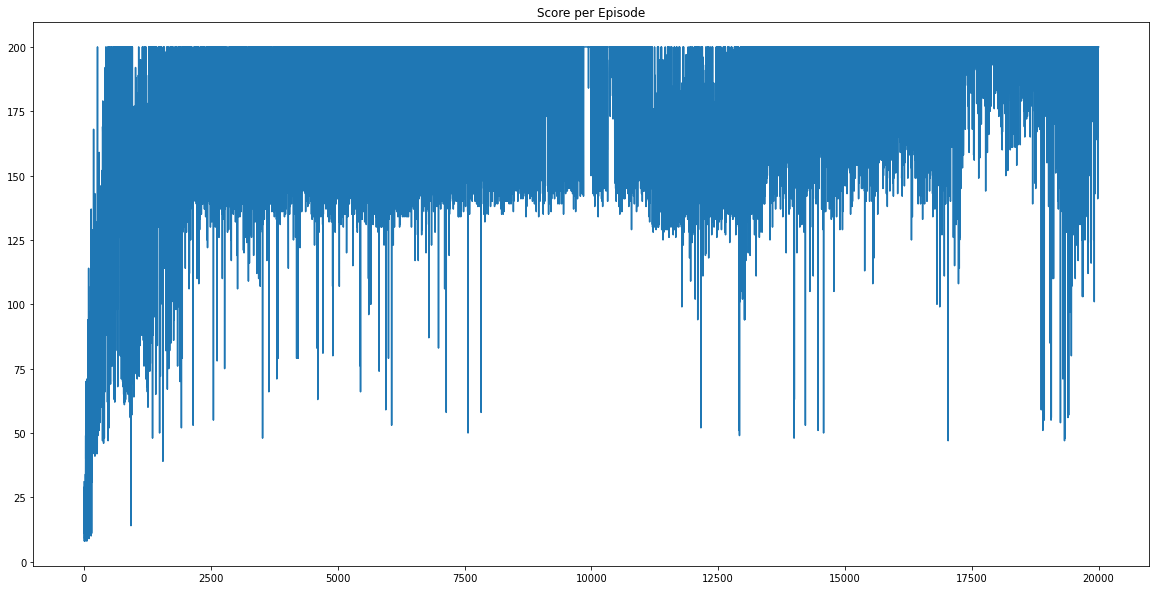

In [7]:
# Score per Episode
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(total_itr)
plt.title("Score per Episode")
plt.show()

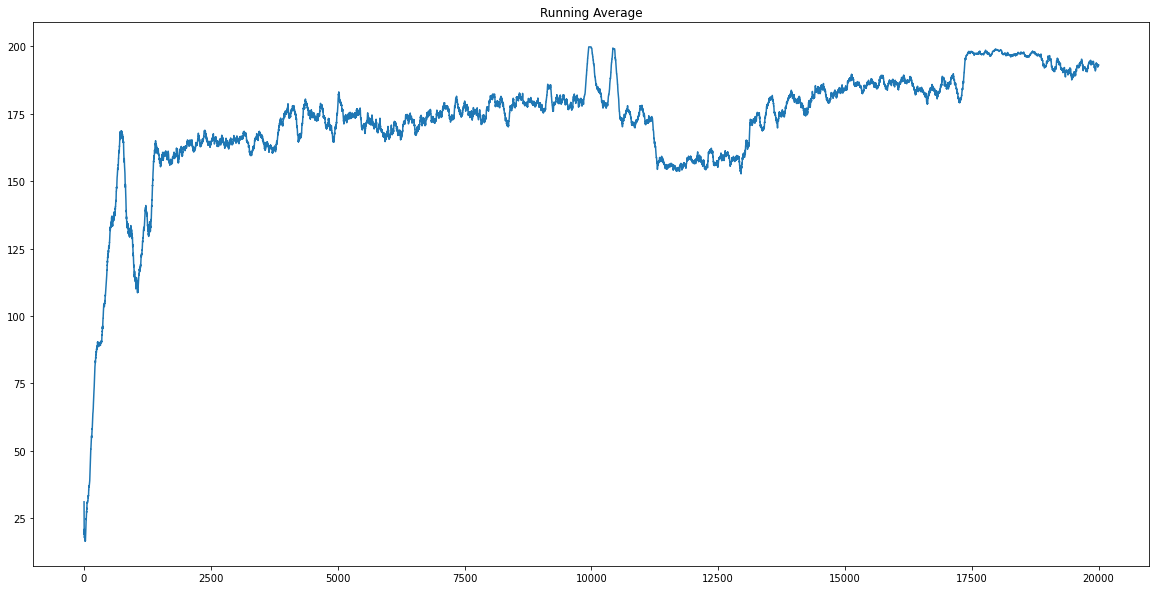

In [8]:
# Running average
fig, ax = plt.subplots(figsize=(20, 10))
N = len(np.array(total_itr))
running_avg = np.empty(N)
for t in range(N):
    running_avg[t] = np.array(total_itr)[max(0, t-100):(t+1)].mean()
plt.plot(running_avg)
plt.title("Running Average")
plt.show()

In [9]:
play_multiple_episodes(env=env,decision_function=decision_Q,N=1000)

Min Duration:  122.0
Average Duration:  192.961
Max Duration:  200.0
Standard Deviation:  16.43


192.961

## MountainCar
Get an under powered car to the top of a hill (top = 0.5 position).

In [10]:
# MountainCar environment from gym
MountainCar = gym.make('MountainCar-v0')
env = MountainCar

In [11]:
position_bins = np.linspace(-1.2, 0.6, 19)
velocity_bins = np.linspace(-0.07, 0.07, 19)

env_bins = [position_bins,velocity_bins]

In [12]:
# Diccionario Q
Q = {}
gamma = 0.9
eps = 0.0001
alpha = 0.5

In [13]:
# Q - learning
total_itr = []
for i in range(50000):
    observation = env.reset()
    done = False
    itr = 0
    state = []
    for idx,obs in enumerate(observation):
        state.append(to_bin(obs,env_bins[idx]))
    state = build_state(state)
    while not done:
        if state not in Q:
            Q[state] = np.random.uniform(low=-1, high=1, size=env.action_space.n)
        if np.random.random() > eps:
            action = np.argmax(Q[state])
        else:
            action = env.action_space.sample()
        observation, reward, done, _ = env.step(action)
        new_state = []
        for idx,obs in enumerate(observation):
            new_state.append(to_bin(obs,env_bins[idx]))
        new_state = build_state(new_state)
        if new_state not in Q:
            Q[new_state] = np.random.uniform(low=-1, high=1, size=env.action_space.n)
        if done and itr < 195:
            reward = 2000-10*itr
        # Actualizamos valor de Q
        q_state = Q[state]
        q_state[action] = q_state[action] + alpha*(reward+gamma*Q[new_state].max()-q_state[action])
        Q[state] = q_state
        state = new_state
        itr += 1
    total_itr.append(itr)

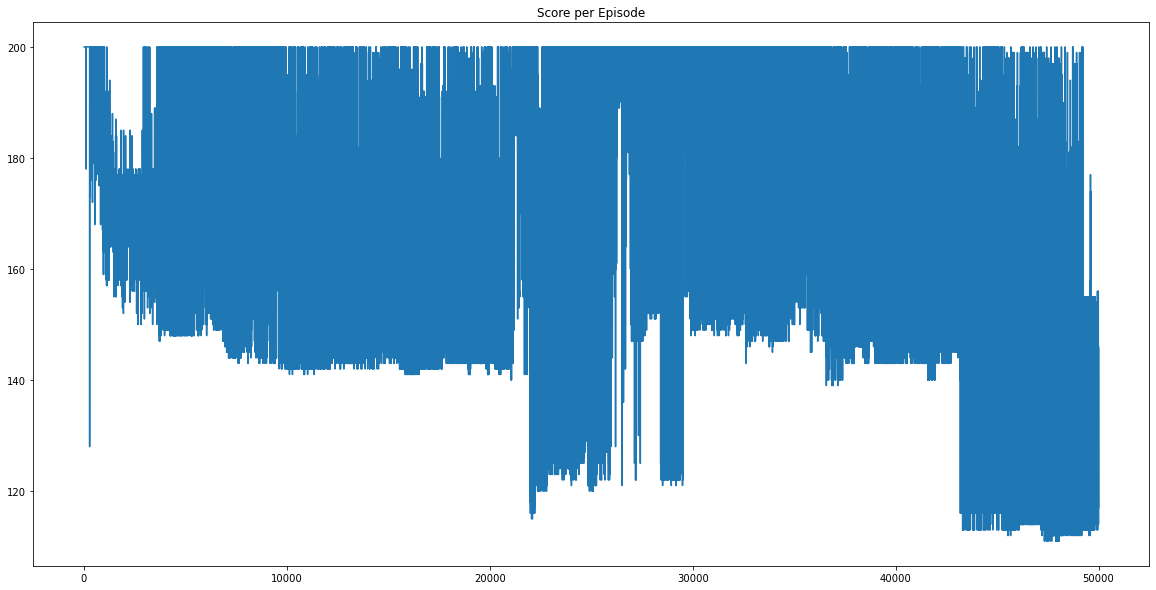

In [14]:
# Score per Episode
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(total_itr)
plt.title("Score per Episode")
plt.show()

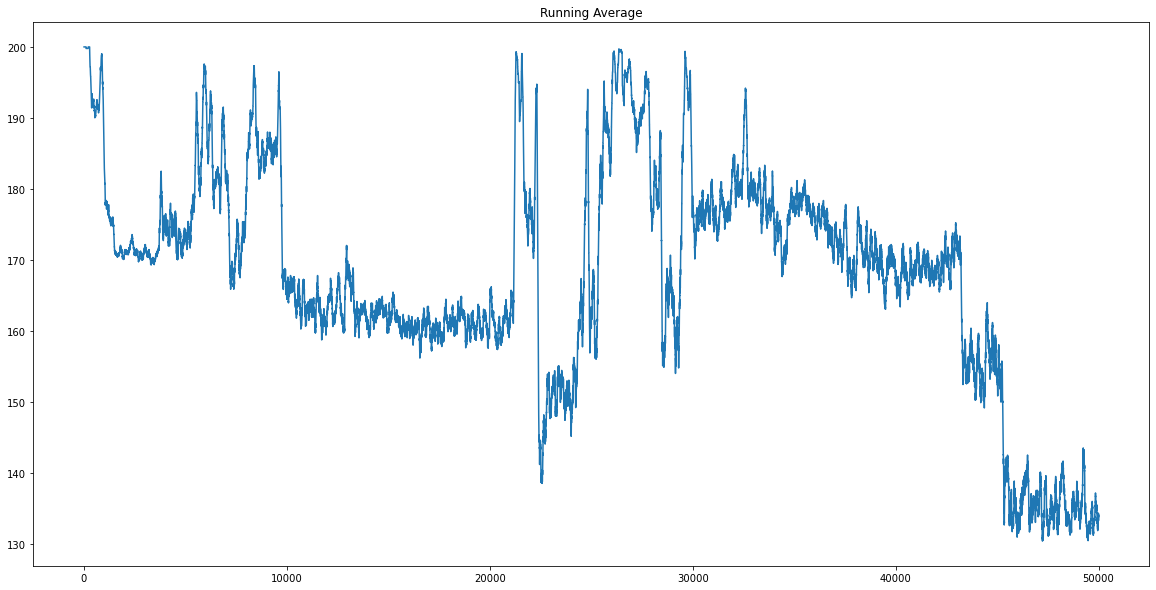

In [15]:
# Running average
fig, ax = plt.subplots(figsize=(20, 10))
N = len(np.array(total_itr))
running_avg = np.empty(N)
for t in range(N):
    running_avg[t] = np.array(total_itr)[max(0, t-100):(t+1)].mean()
plt.plot(running_avg)
plt.title("Running Average")
plt.show()

In [16]:
play_multiple_episodes(env=env,decision_function=decision_Q,N=1000)

Min Duration:  113.0
Average Duration:  135.876
Max Duration:  157.0
Standard Deviation:  14.72


135.876

April 5, 2020